## Setup

Hungging face dll

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install transformers==2.8.0

In [ ]:
!pip install langdetect

In [ ]:

%reload_ext watermark
# %watermark -v -p numpy,pandas,torch,transformers

In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from langdetect import detect
from textblob import TextBlob

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

dataset yang sudah di preprocess

In [ ]:
df=pd.read_csv("train_clear.csv")
df.rename({'category':'sentiment'},axis=1,inplace=True)

test=pd.read_csv("test_clear.csv")
test.rename({'category':'sentiment'},axis=1,inplace=True)

df.fillna(" ",inplace=True)
df.drop(['Unnamed: 0','english'],axis=1,inplace=True)
test.fillna(" ",inplace=True)
test.drop(['Unnamed: 0'],axis=1,inplace=True)


dibawah ini merupakan kelas dan fungsi preprocesing yang telah dilakukan

In [ ]:
class correct_my_string:
  from textblob import TextBlob
  
  def __init__(self, string):

    self._string = string.lower()
    self._alay_dict = pd.read_csv(root_path+"colloquial-indonesian-lexicon.csv")[['slang', 'formal']].set_index('slang').to_dict()['formal']
    f = open(root_path+'kata-dasar-all.txt', 'r')
    x = f.readlines()
    f.close()
    self._indo_dictionary = [ z.strip('\n') for z in x]
  
  def english_to_indo(self, word):

    d = enchant.Dict("en_US")
    if d.check(word):
      coba = TextBlob(word)
      return str(coba.translate(from_lang='en', to='id'))
    else:
      return None

  def check_alay(self, word):
    if word in self._alay_dict:
      return self._alay_dict[word]
    else:
      return None

  def correct_word(self, word):
    from symspellpy import SymSpell, Verbosity

    sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
    sym_spell.load_dictionary(root_path+"word_dist.txt", term_index=0, count_index=1)
    suggestions = sym_spell.lookup("hri", Verbosity.CLOSEST,
                                  max_edit_distance=2, include_unknown=True)
    
    return str(suggestions[0]).split(",")[0]

  def check_word_existence(self, word):
    if word in self._indo_dictionary:
      return word
    else:
      return None

  def _stem_my_string(self):
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

    # create stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # stemming process
    return stemmer.stem(self._string)
  
  def standardize_my_string(self, stemmed=True):

    import re 
    if stemmed == True: 
      my_string = self._stem_my_string()
    else:
      my_string = self._string 
    splitted = [ x for x in my_string.split() if re.match(r'^[A-za-z]+$', x)]
    corrected = []

    for z in splitted:
      um = self.check_word_existence(z)
      if um:
        corrected.append(um)
      else: 
        am = self.check_alay(z)
        if am:
          corrected.append(am)
        else:
          em = self.english_to_indo(z)
          if em:
            corrected.append(em)
          else:
            um = self.correct_word(z)
            corrected.append(em)

    return " ".join([ x for x in corrected if x])

def correct_all_string(string):
  check = correct_my_string(string)
  return check.standardize_my_string()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14856 entries, 0 to 14855
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    14856 non-null  object
 1   review_text  14856 non-null  object
 2   sentiment    14856 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 348.3+ KB


In [ ]:
import imblearn

In [ ]:
from imblearn.over_sampling import RandomOverSampler

split dulu sebelom oversample

In [ ]:
df_train.sentiment.value_counts()

0    12839
1     2017
Name: sentiment, dtype: int64

In [ ]:
df_train, df_test = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

yak kita oversample

In [ ]:
oversample = RandomOverSampler(sampling_strategy=0.5)

X_over, y_over = oversample.fit_resample(df_train.drop('sentiment',axis=1), df_train['sentiment'])

qw = pd.DataFrame(data=y_over,columns=["sentiment"])

zx = pd.DataFrame(data=X_over,columns=["review_id", "review_text"])

df_train=pd.merge(zx, qw, left_index=True, right_index=True)

df_train.sentiment.value_counts()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0    11553
1     5776
Name: sentiment, dtype: int64

In [ ]:
df_val.sentiment.value_counts()

0    634
1    109
Name: sentiment, dtype: int64

In [ ]:
df_test.sentiment.value_counts()

0    652
1     91
Name: sentiment, dtype: int64

In [ ]:
df.review_text.dtypes

dtype('O')

In [ ]:
df=df_train.copy()

In [ ]:
df.shape

(17329, 3)

We have about 16k examples. Let's check for missing values:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17329 entries, 0 to 17328
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    17329 non-null  object
 1   review_text  17329 non-null  object
 2   sentiment    17329 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 406.3+ KB


lumayan lah, sebelum sangat imablance

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


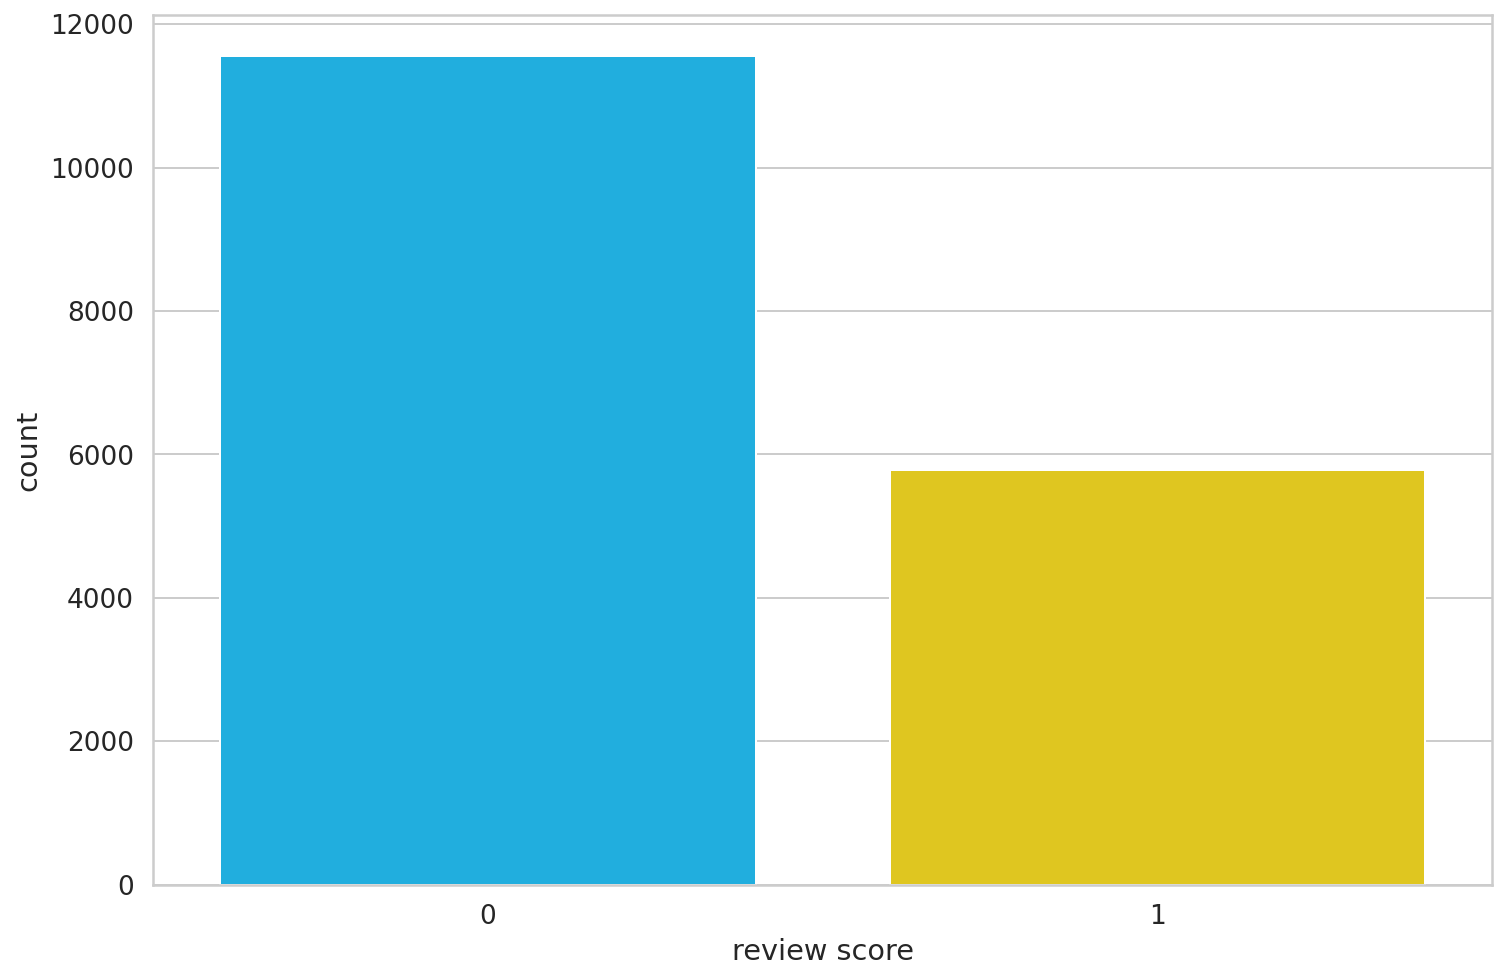

In [ ]:
sns.countplot(df.sentiment)
plt.xlabel('review score');

## Data Preprocessing

kita gunakan indobert dari indobenchmark

In [ ]:
PRE_TRAINED_MODEL_NAME = 'indobenchmark/indobert-base-p1'

get [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Special Tokens

contoh2 token

`[SEP]` - akhir sentence


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 3)

`[CLS]` - start sentence

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 2)

padding

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

unkown

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 1)

jalan kan semua [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

### Choosing Sequence Length

ayo kita tentukan panjang token yang tepat

In [ ]:
token_lens = []

for txt in df.review_text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

plot distribution:

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


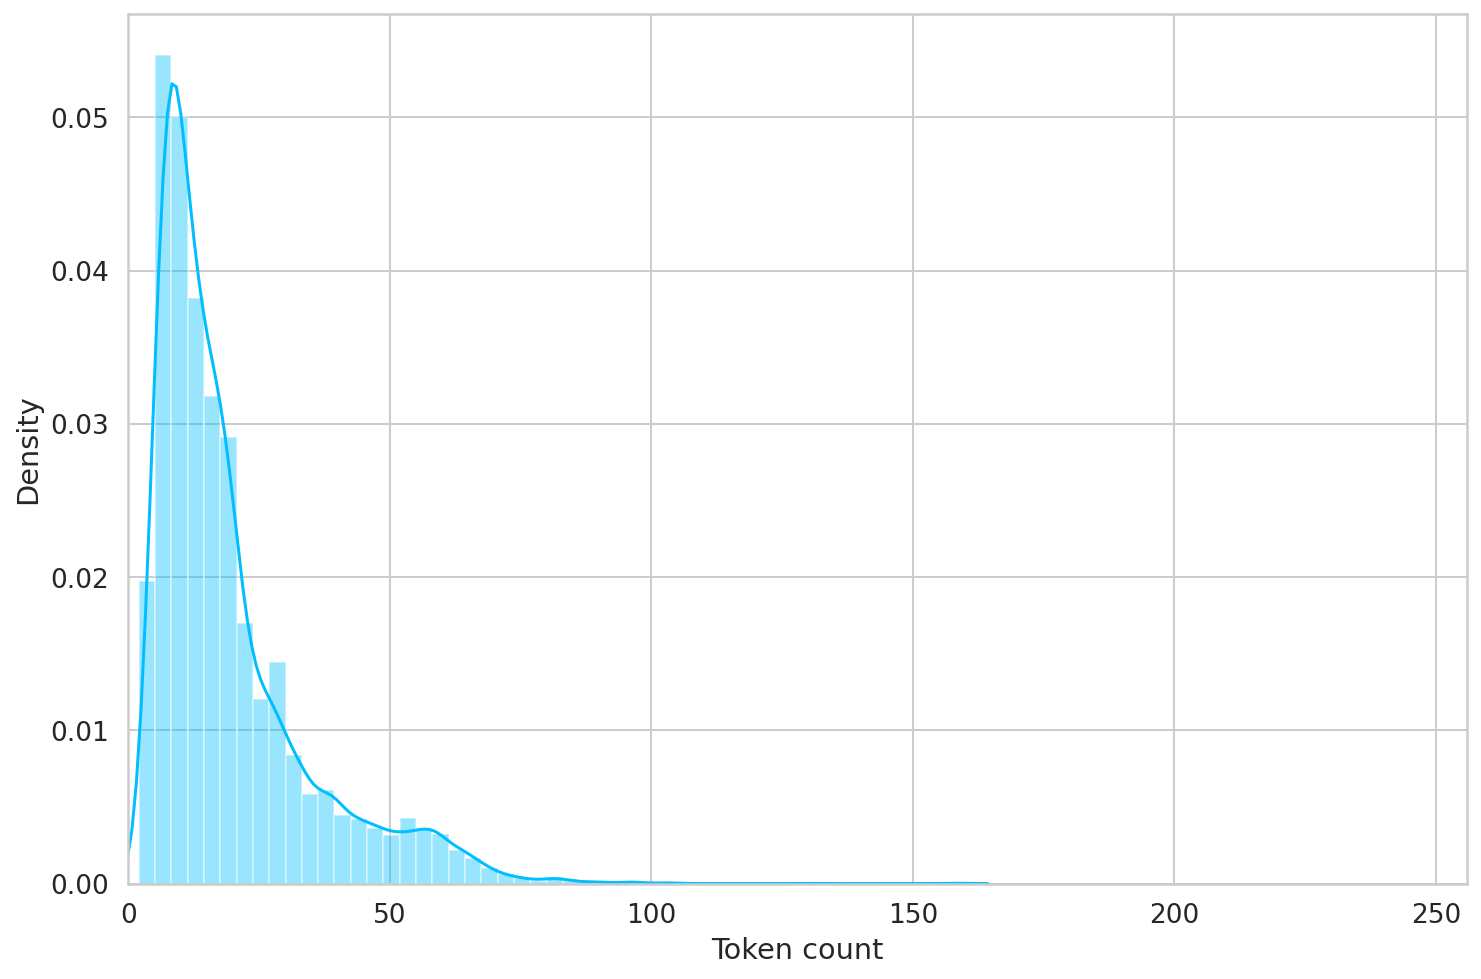

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

ada maks di 150an, kita ambil 160

In [ ]:
MAX_LEN = 160

build pytorch dataset

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }



```
# This is formatted as code
```

cek data

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((17329, 3), (743, 3), (743, 3))

bikin data loader

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review_text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

cek data loader

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [ ]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4360, 0.5640],
        [0.5240, 0.4760],
        [0.5686, 0.4314],
        [0.7388, 0.2612],
        [0.5792, 0.4208],
        [0.5982, 0.4018],
        [0.6894, 0.3106],
        [0.5435, 0.4565],
        [0.4540, 0.5460],
        [0.5464, 0.4536],
        [0.6080, 0.3920],
        [0.6672, 0.3328],
        [0.8036, 0.1964],
        [0.5099, 0.4901],
        [0.5270, 0.4730],
        [0.7473, 0.2527]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 40

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  true_positive = 0
  true_negative = 0 
  false_positive = 0 
  false_negative = 0
  target_positive = 0 
  target_negative = 0 
  predicted_true = 0 
  predicted_negative = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)

    true_positive += torch.sum((preds == 1)&(targets == 1))
    true_negative += torch.sum((preds == 0)&(targets == 0))
    false_positive += torch.sum((preds == 1)&(targets == 0))
    false_negative += torch.sum((preds == 0)&(targets == 1))

    target_positive += torch.sum((targets == 1))
    target_negative += torch.sum((targets == 0))

    predicted_true += torch.sum((preds == 1))
    predicted_negative += torch.sum((preds == 0))
    
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  recall = true_positive / target_positive
  precision = true_positive / predicted_true
  f1_score = 2 * precision * recall / (precision + recall)
  accuracy_calculated = (true_positive + true_negative)/ (target_positive + target_negative)
  

  return correct_predictions.double() / n_examples, np.mean(losses), recall, precision, f1_score, accuracy_calculated

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  true_positive = 0
  true_negative = 0 
  false_positive = 0 
  false_negative = 0
  target_positive = 0 
  target_negative = 0 
  predicted_true = 0 
  predicted_negative = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)


      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)

      true_positive += torch.sum((preds == 1)&(targets == 1))
      true_negative += torch.sum((preds == 0)&(targets == 0))
      false_positive += torch.sum((preds == 1)&(targets == 0))
      false_negative += torch.sum((preds == 0)&(targets == 1))

      target_positive += torch.sum((targets == 1))
      target_negative += torch.sum((targets == 0))

      predicted_true += torch.sum((preds == 1))
      predicted_negative += torch.sum((preds == 0))

      losses.append(loss.item())

    
    recall = true_positive / target_positive
    precision = true_positive / predicted_true
    f1_score = 2 * precision * recall / (precision + recall)
    accuracy_calculated = (true_positive + true_negative)/ (target_positive + target_negative)
    

  return correct_predictions.double() / n_examples, np.mean(losses), recall, precision, f1_score, accuracy_calculated

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, train_recall, train_precision, train_f1_score, train_accv2 = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc} f1 {train_f1_score}')

  val_acc, val_loss, val_recall, val_precision, val_f1_score, val_accv2 = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc} f1 {val_f1_score}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['train_f1_score'].append(train_f1_score)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  history['val_recall'].append(val_recall)
  history['vall_precision'].append(val_precision)
  history['val_f1_score'].append(val_f1_score)
  history['val_accv2'].append(val_accv2)

  if val_f1_score > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_f1_score

Epoch 1/40
----------


/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss 0.17215015391914465 accuracy 0.9517571700617462 f1 0.9251566529273987
Val   loss 7.1639333380029555 accuracy 0.14670255720053835 f1 0.2558685541152954

Epoch 2/40
----------
Train loss 0.1920176009317432 accuracy 0.9538923192336546 f1 0.9302975535392761
Val   loss 6.655417909013464 accuracy 0.14670255720053835 f1 0.2558685541152954

Epoch 3/40
----------
Train loss 0.16753697055303904 accuracy 0.9614519014368977 f1 0.9421043395996094
Val   loss 7.623473542801877 accuracy 0.14670255720053835 f1 0.2558685541152954

Epoch 4/40
----------
Train loss 0.18652179076328163 accuracy 0.9570084828899533 f1 0.9353467226028442
Val   loss 5.895082473754883 accuracy 0.14670255720053835 f1 0.2558685541152954

Epoch 5/40
----------
Train loss 0.18433782964353582 accuracy 0.9586242714524785 f1 0.9372318387031555
Val   loss 5.754369086407601 accuracy 0.14670255720053835 f1 0.2558685541152954

Epoch 6/40
----------
Train loss 0.21679905105745303 accuracy 0.9461019100929079 f1 0.9202391505241394

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

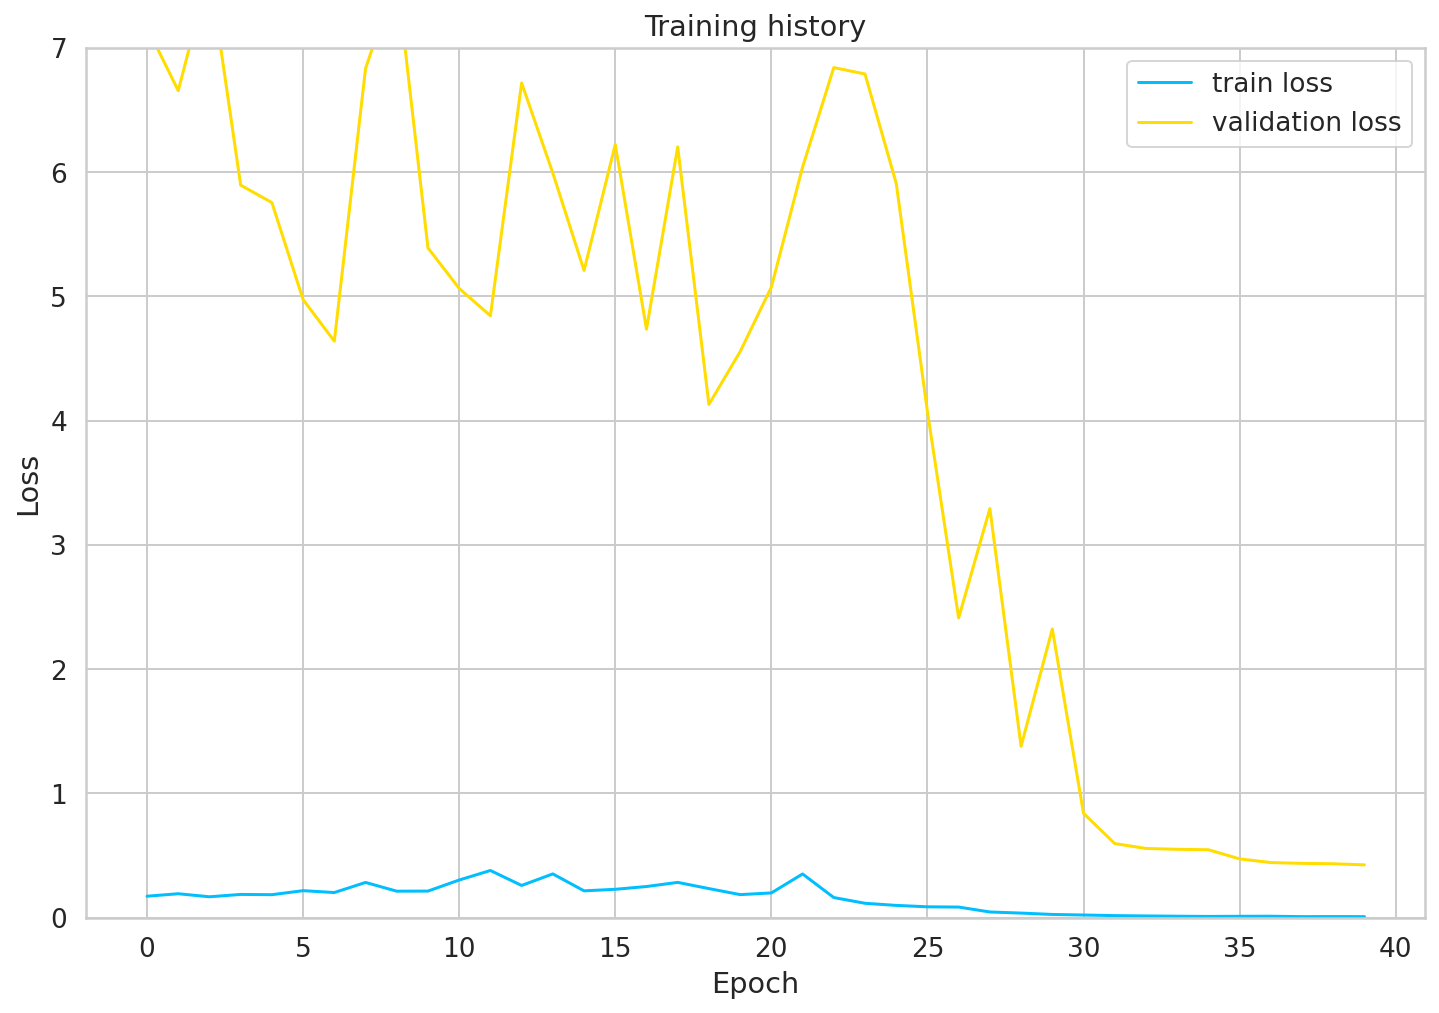

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 7]);

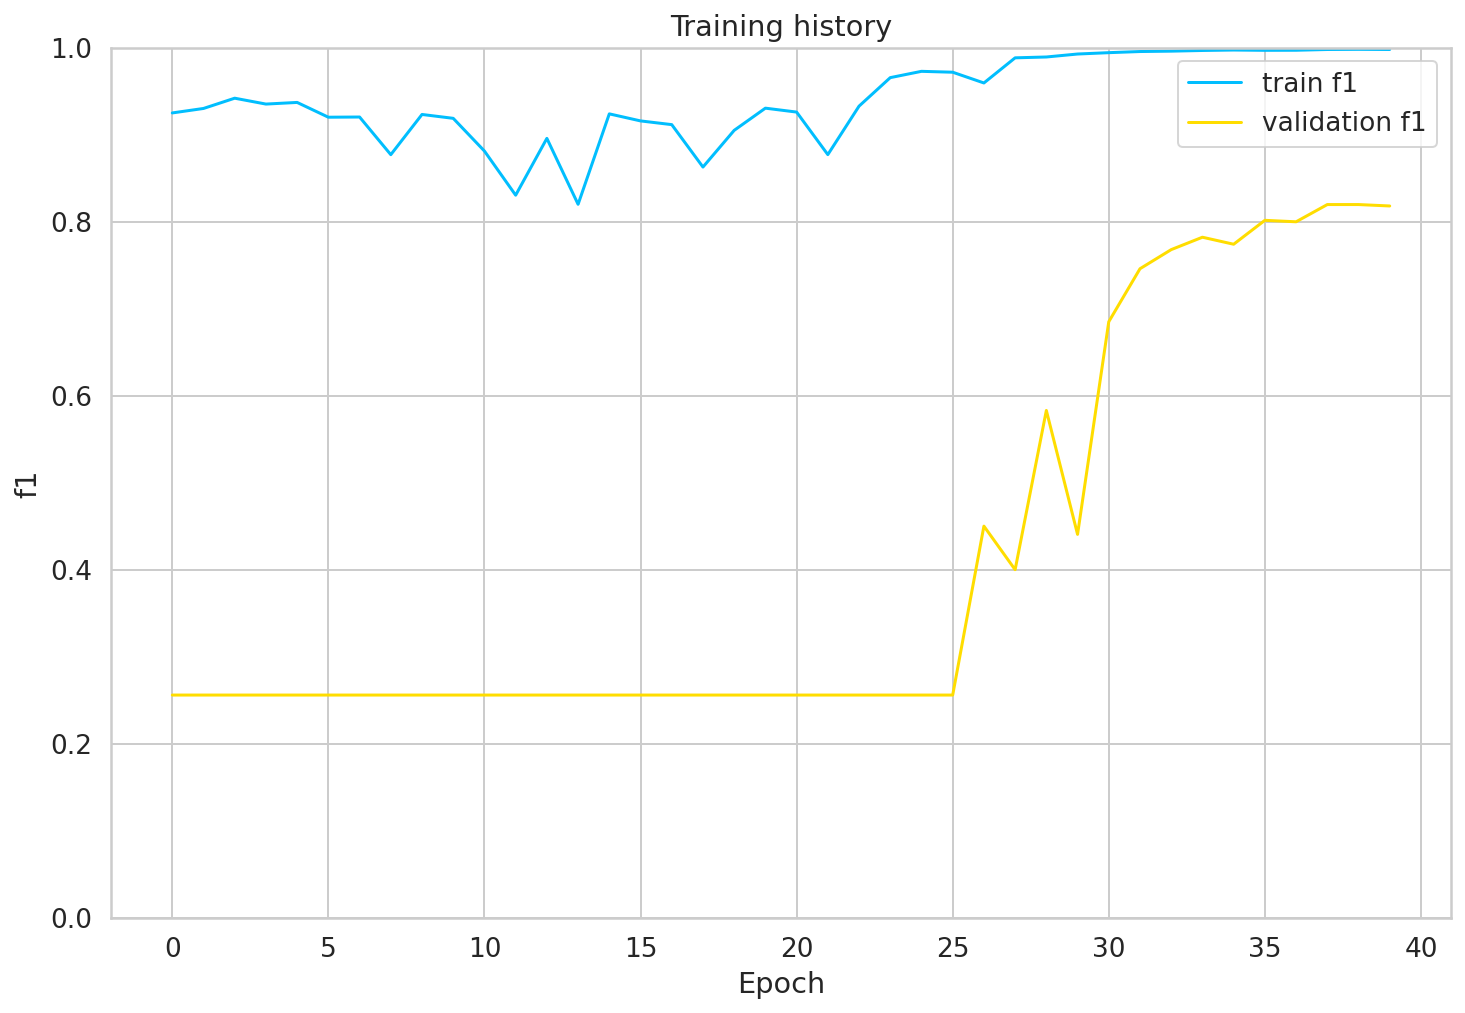

In [ ]:
plt.plot(history['train_f1_score'], label='train f1')
plt.plot(history['val_f1_score'], label='validation f1')

plt.title('Training history')
plt.ylabel('f1')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

sepertinya butuh lebih banyak epoch

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, test_loss, test_recall, test_precision, test_f1_score, test_accv2 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print(f'Val   loss {test_loss} accuracy {test_acc} f1 {test_f1_score}')
print()

test_acc.item()

Val   loss 0.3608755340584197 accuracy 0.9502018842530283 f1 0.800000011920929



0.9502018842530283

In [ ]:
len(df_test)

743

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.97      0.97      0.97       652
    positive       0.79      0.81      0.80        91

    accuracy                           0.95       743
   macro avg       0.88      0.89      0.89       743
weighted avg       0.95      0.95      0.95       743



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

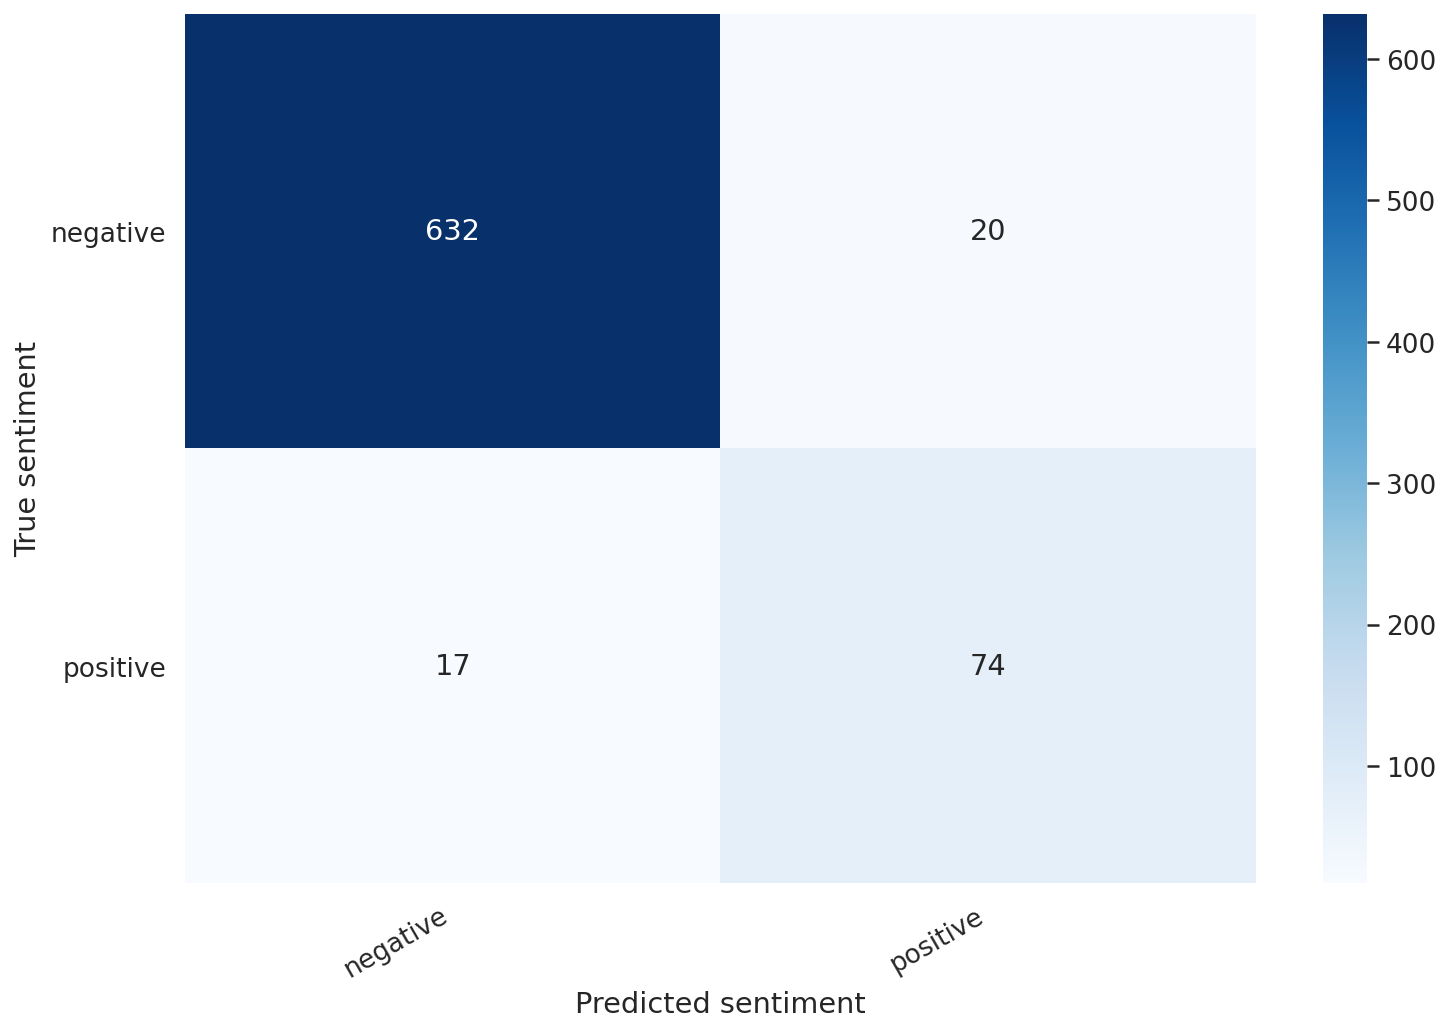

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
idx = 8

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

lumayan tapi kamar mandi agak genang lama durutnya

True sentiment: negative


Now we can look at the confidence of each sentiment of our model:

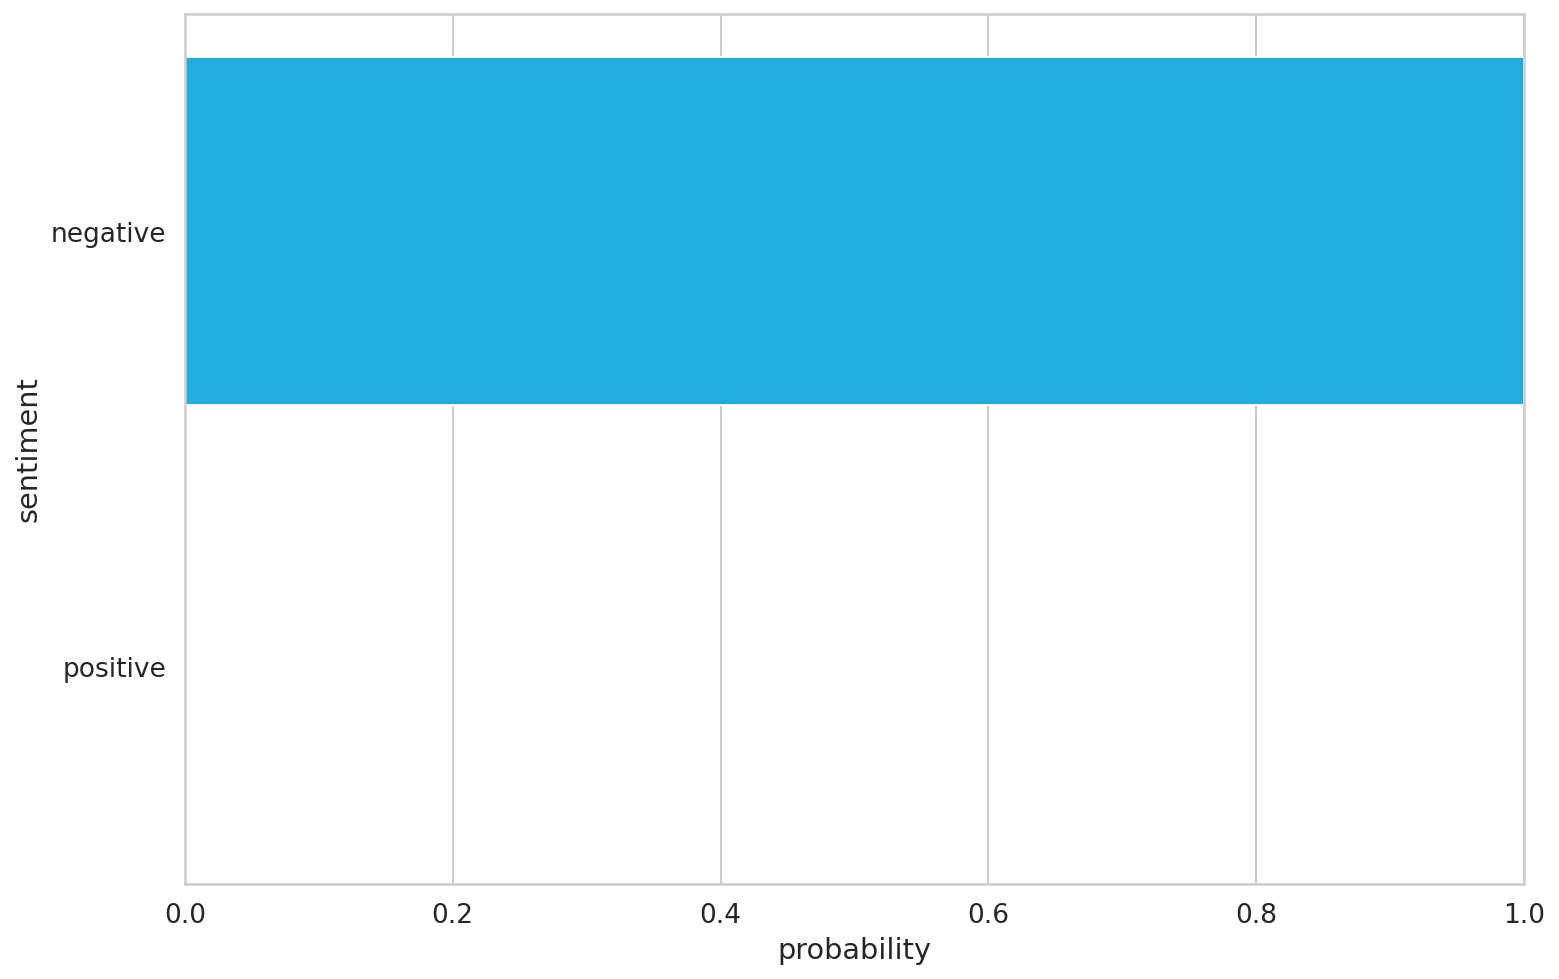

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
x=pd.DataFrame((list(y_pred_probs.numpy())))

In [ ]:
x['true']=y_test.numpy()

In [ ]:
x['text']=review_text

In [ ]:
x.to_csv("eval.csv")

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : negative


## Summary

Nice job! You learned how to use BERT for sentiment analysis. You built a custom classifier using the Hugging Face library and trained it on our app reviews dataset!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Next, we'll learn how to deploy our trained model behind a REST API and build a simple web app to access it.

## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)

In [ ]:
tez = test.copy()

In [ ]:
tez['category']=None

In [ ]:
for i in tez.index:
  review_text = tez.loc[i,'review_text']
  encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  print(f'Review text: {review_text}')
  print(f'Sentiment  : {class_names[prediction]}')
  print('-')
  tez.loc[i,'category']=class_names[prediction]


Streaming output truncated to the last 5000 lines.
Sentiment  : negative
-
Review text: sempit sih parkir mobil dan air hangat tidak fungsi
Sentiment  : negative
-
Review text: rasa tipu uang tidak kembali jelek
Sentiment  : negative
-
Review text: kamar luas untuk twin bersih nyaman ac dingin air lancar cuma air anget nya lagi oof
Sentiment  : positive
-
Review text: hotel dekat dengan ramai layan ramah tapi kamar mandi pada hari pertama tidak ada handuk
Sentiment  : positive
-
Review text: overall good but the jet pump is very annoying
Sentiment  : positive
-
Review text: kamar cukup bagus dan fisilitas cukup lengkap namun handuk lihat kotor karena ada bercak seperti karat dan hari dua tidak dapat air minum
Sentiment  : negative
-
Review text: sangat senang dan muas
Sentiment  : positive
-
Review text: review jujur aja ya view dari dalem kamar bagus banget kita bisa city light terus bisa liat sunrise dengan jelas tapi fasilitas kamar bukan standar airy room enggak ada handuk air pana

In [ ]:
tez.category.value_counts()

negative    3198
positive     516
Name: category, dtype: int64

In [ ]:
# tez.rename({'pred':'category'},axis=1,inplace=True)

In [ ]:
tez.replace({'category': {'negative': 0, 'positive': 1}}).to_csv('submit_test_eval.csv',index=False)

In [ ]:
tez.replace({'category': {'negative': 0, 'positive': 1}}).drop('review_text',axis=1).to_csv('submit.csv',index=False)

In [ ]:
qwe=df.copy()

In [ ]:
qwe['pred']=None

In [ ]:
for i in qwe.index:
  review_text = qwe.loc[i,'review_text']
  encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  print(f'Review text: {review_text}')
  print(f'Sentiment  : {class_names[prediction]}')
  print('-')
  qwe.loc[i,'pred']=class_names[prediction]


Streaming output truncated to the last 5000 lines.
Sentiment  : positive
-
Review text: terimakasih airy dan terimakasih hotel museum batik hotel recomended tempat dekat enggak
Sentiment  : positive
-
Review text: murah riah untuk ukur hotel bintang dekat dengan kota
Sentiment  : positive
-
Review text: para staf sangat ramah bersih cukup baik lokasi strategis makan cukup baik bahkan di sekitar hotel banyak sekali yang jual makan kalau ingin coba makan lain point utama yang buat saya senang di sini adalah konsep syariah yang di usung hotel buat saya rasa aman dan nyaman recommended untuk keluarga pribadi yang ingin suasana yang aman dan nyaman
Sentiment  : positive
-
Review text: nyaman tempat luas strategis
Sentiment  : positive
-
Review text: paling suka bagi kamar mandi air lancar
Sentiment  : positive
-
Review text: ain enak sbanget layan bagus tempat bersih banget cuma kolam renang yang kotor
Sentiment  : positive
-
Review text: tempat bersih dekat dengan pusat di bal
Sentiment  :

In [ ]:
qwe.pred.value_counts()

negative    11548
positive     5781
Name: pred, dtype: int64

In [ ]:
qwe.replace({'pred': {'negative': 0, 'positive': 1}}).to_csv('submit_train.csv')

In [ ]:
qwe.sentiment.value_counts()

0    11553
1     5776
Name: sentiment, dtype: int64

In [ ]:
qwe.pred.value_counts()

negative    11548
positive     5781
Name: pred, dtype: int64

In [ ]:
df.sentiment.value_counts()

0    11553
1     5776
Name: sentiment, dtype: int64

In [ ]:
from google.colab import files
files.download('submit.csv') 
files.download('submit_train.csv') 
files.download('submit_test_eval.csv') 
files.download('eval.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>